## LABORATORIO 8 
### ATAQUES Y DEFENSA 


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

DIMENSION = 256
loaded_model = load_model('Amodel')
x_stealed_loaded = np.load('x_val.npy')
y_stealed_loaded = np.loadtxt('y_val.txt', delimiter=',')

### ATAQUE ADVERSIDAL

In [2]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
classifier = KerasClassifier(loaded_model)

In [4]:
attack_fgsm = FastGradientMethod(
  estimator=classifier, 
  eps=2.7
)

In [5]:
test_images_adv = attack_fgsm.generate(x=x_stealed_loaded)

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [6]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


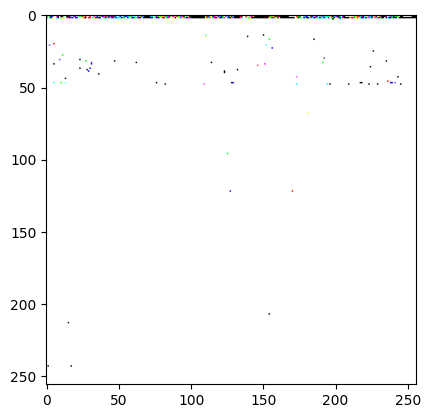

In [7]:
plt.imshow(X=test_images_adv[0])

In [8]:
score_original = classifier._model.evaluate(
  x=x_stealed_loaded,
  y=y_stealed_loaded
)

score_stolen = classifier._model.evaluate(
  x=test_images_adv,
  y=y_stealed_loaded
)

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "  f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " f"vs adversarial test accuracy: {score_stolen[1]:.2f}")

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Original test loss: 0.34 vs stolen test loss: 7.22
Original test accuracy: 0.96 vs adversarial test accuracy: 0.39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


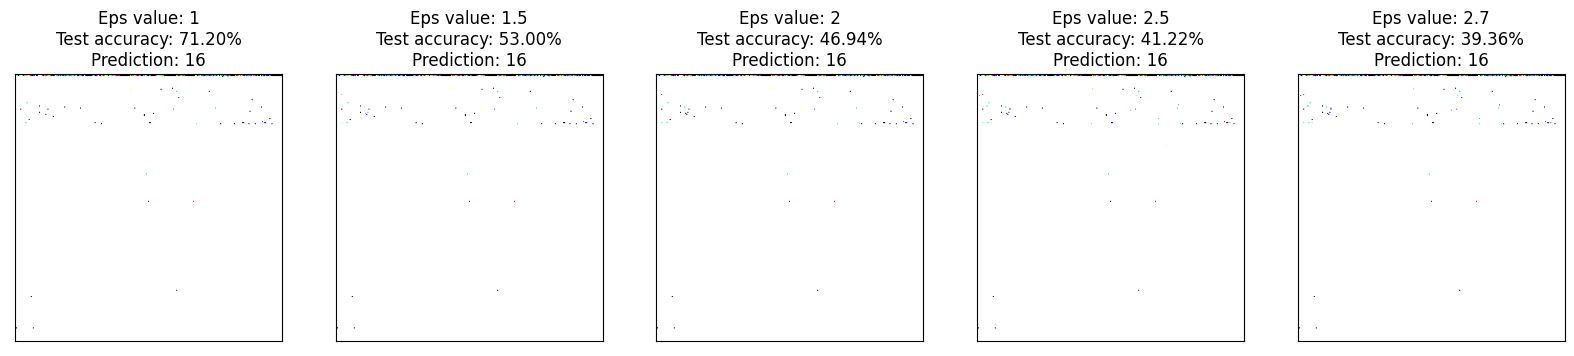

In [9]:
nrows, ncols = 1, 5

fig, axes = plt.subplots(
  nrows=nrows, 
  ncols=ncols, 
  figsize=(20, 10)
)

eps_to_try = [1, 1.5, 2, 2.5, 2.7]

counter = 0

for j in range(ncols):    
  attack_fgsm = FastGradientMethod(
    estimator=classifier, 
    eps=eps_to_try[counter]
  )

  test_images_adv = attack_fgsm.generate(x=x_stealed_loaded)
  axes[j].imshow(X=test_images_adv[0])

  # Disabling x and y ticks
  axes[j].set_xticks(ticks=[])
  axes[j].set_yticks(ticks=[])

  test_score = classifier._model.evaluate(
    x=test_images_adv, 
    y=y_stealed_loaded
  )[1]

  prediction = np.argmax(loaded_model.predict(
    x=np.expand_dims(a=test_images_adv[0], 
    axis=0)
  ))    

  axes[j].set_title(
    label=f"Eps value: {eps_to_try[counter]}\n"
    f"Test accuracy: {test_score * 100:.2f}%\n"
    f"Prediction: {prediction}"
  )

  counter += 1

plt.show()

### DEFENSA DEL ATAQUE ADVERSARIAL

In [10]:
from art.defences.preprocessor import SpatialSmoothing

In [11]:
defence_adv = SpatialSmoothing(window_size=3)

In [12]:
x_art_def, _ = defence_adv(x_stealed_loaded)
x_art_adv_def, _ = defence_adv(test_images_adv)

In [13]:
score_original = classifier._model.evaluate(
  x=x_art_def,
  y=y_stealed_loaded
)

score_stolen = classifier._model.evaluate(
  x=x_art_adv_def,
  y=y_stealed_loaded
)

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "  f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " f"vs adversarial test accuracy: {score_stolen[1]:.2f}")

Original test loss: 0.69 vs stolen test loss: 1.03
Original test accuracy: 0.86 vs adversarial test accuracy: 0.79


### ATAQUES DE EXTRACCION 

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model, Sequential
import tensorflow as tf
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense

tf.compat.v1.disable_eager_execution()

DIMENSION = 256
loaded_model = load_model('Amodel')
x_stealed_loaded = np.load('x_val.npy')
y_stealed_loaded = np.loadtxt('y_val.txt', delimiter=',')

In [3]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_stealed_loaded, y_stealed_loaded, test_size=0.30, random_state=1)

In [4]:
from art.estimators.classification import KerasClassifier
classifier = KerasClassifier(loaded_model)

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from art.attacks.extraction import CopycatCNN
copycat_cnn = CopycatCNN(
  batch_size_fit=16,
  batch_size_query=16,
  nb_epochs=5,
  nb_stolen=len(X_train_s),
  classifier=classifier
)

In [6]:
def createBlankModel():
  stolen_m = Sequential()
  stolen_m.add(Convolution2D(32, (3, 3), strides=(1, 1), input_shape=(DIMENSION, DIMENSION, 3), activation='relu'))
  stolen_m.add(MaxPooling2D(pool_size=(2, 2)))
  stolen_m.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
  stolen_m.add(MaxPooling2D(pool_size=(2, 2)))
  stolen_m.add(Flatten())
  stolen_m.add(Dense(512, activation='softplus'))
  stolen_m.add(Dense(25, activation='sigmoid'))

  stolen_m.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )
  return stolen_m

In [7]:
model_stolen = KerasClassifier(model=createBlankModel())

In [8]:
stolen_classifier = copycat_cnn.extract(
  x=X_train_s, 
  y=y_train_s, 
  thieved_classifier=model_stolen
)

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 3269 samples
Epoch 1/5
3269/3269 [==============================] - 272s 83ms/sample - loss: 171.0897 - accuracy: 0.8113
Epoch 2/5
3269/3269 [==============================] - 208s 64ms/sample - loss: 0.1312 - accuracy: 0.9743
Epoch 3/5
3269/3269 [==============================] - 196s 60ms/sample - loss: 0.0530 - accuracy: 0.9872
Epoch 4/5
3269/3269 [==============================] - 217s 66ms/sample - loss: 0.0466 - accuracy: 0.9890
Epoch 5/5
3269/3269 [==============================] - 233s 71ms/sample - loss: 0.0569 - accuracy: 0.9875


In [9]:
score_original = classifier._model.evaluate(
  x=X_test_s,
  y=y_test_s
)

score_stolen = stolen_classifier._model.evaluate(
  x=X_test_s,
  y=y_test_s
)

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "  f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " f"vs stolen test accuracy: {score_stolen[1]:.2f}")

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Original test loss: 0.40 vs stolen test loss: 2.99
Original test accuracy: 0.94 vs stolen test accuracy: 0.83


### DEFENSA DEL ATAQUE

In [10]:
from art.defences.postprocessor import ReverseSigmoid

In [11]:
post_processor = ReverseSigmoid(
  beta=1.0,
  gamma=0.2
)

classifier_def = KerasClassifier(
  model=loaded_model,
  postprocessing_defences=post_processor,
)

In [12]:
model_stolen_def = KerasClassifier(model=createBlankModel())

copycat_cnn_def = CopycatCNN(
  batch_size_fit=16,
  batch_size_query=16,
  nb_epochs=5,
  nb_stolen=len(X_train_s),
  classifier=classifier_def
)

stolen_classifier_def = copycat_cnn_def.extract(
  x=X_train_s, 
  y=y_train_s, 
  thieved_classifier=model_stolen_def
)

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\art\defences\postprocessor\reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 3269 samples
Epoch 1/5
3269/3269 [==============================] - 237s 73ms/sample - loss: 140.9559 - accuracy: 0.3536
Epoch 2/5
3269/3269 [==============================] - 233s 71ms/sample - loss: 1.4607 - accuracy: 0.5402
Epoch 3/5
3269/3269 [==============================] - 233s 71ms/sample - loss: 0.9775 - accuracy: 0.6620
Epoch 4/5
3269/3269 [==============================] - 225s 69ms/sample - loss: 0.8329 - accuracy: 0.6920
Epoch 5/5
3269/3269 [==============================] - 234s 72ms/sample - loss: 0.8439 - accuracy: 0.7134


In [13]:
score_original = classifier_def._model.evaluate(
  x=X_test_s,
  y=y_test_s
)

score_stolen = stolen_classifier_def._model.evaluate(
  x=X_test_s,
  y=y_test_s
)

# Comparing test losses
print(f"Original loss: {score_original[0]:.2f} "  f"vs stolen loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original accuracy: {score_original[1]:.2f} " f"vs stolen accuracy: {score_stolen[1]:.2f}")

Original loss: 0.40 vs stolen loss: 7.70
Original accuracy: 0.94 vs stolen accuracy: 0.18
